scheme:

* 1) for data transfer, pick 1st sleep api (h2d) fo stream-0, current cc = 1 (concurrency),
* 2) check whether there is overalp with stream-
* 2) if there is overlap, finish cc=1, start from cc++ (cc=2), predit the future ending time
* 3) during the predicted ending time, check whether there is overlap with stream-2
* 4) if there is overalap, finish cc=2, start from cc++ (cc=3), predict the future ending time
* 5) go to step 3) , search through all the cuda streams
* 6) for each time range, we need to find out how many apis have overlap and which-pair have conflicts or not

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
import pandas as pd
import numpy as np
import os
import sys # error msg, add the modules
import operator # sorting
from math import *
import matplotlib.pyplot as plt

sys.path.append('../../')

import cuda_timeline
import read_trace
import avgblk
import cke
from model_param import *
from df_util import *

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# gpu info

In [3]:
gtx950 = DeviceInfo()
gtx950.sm_num = 6
gtx950.sharedmem_per_sm = 49152
gtx950.reg_per_sm = 65536
gtx950.maxthreads_per_sm = 2048

In [4]:
# init SM resources
SM_resList, SM_traceList = init_gpu(gtx950)

In [4]:
#SM_resList[0]

<model_param.SM_Stat instance at 0x7f3ccd9b7bd8>

In [5]:
SM_traceList[0]

,sm_id,block_id,block_start,block_end,batch_id,kernel_id,active


# kernel info

In [6]:
trace_s1 = 'trace_s1_5m.csv'
df_trace_s1 = read_trace.Trace2dataframe(trace_s1)

trace_s2 = 'trace_s2_5m.csv'
df_trace_s2 = read_trace.Trace2dataframe(trace_s2)

trace_s3 = 'trace_s3_5m.csv'
df_trace_s3 = read_trace.Trace2dataframe(trace_s3)

In [7]:
#df_trace

In [8]:
# extract kernel info from trace
# warning: currently lmted to one kernel
kernel = read_trace.GetKernelInfo(df_trace, gtx950)
print kernel.runtime_ms
print kernel.avg_blk_time
print kernel.blockDim
print kernel.start_ms

0.056961
0.0284805
256.0
0


In [9]:
# for each stream, have a dd for each kernel
stream_kernel_list = []

stream_num = 2
for sid in range(stream_num):
    print sid
    # key will be the kernel order
    # value will be the kernel info
    kern_dd = {}
    kern_dd[0] = Copy_kern_info(kernel)
    stream_kernel_list.append(kern_dd)
    

0
1


In [10]:
s1_kern_dd = stream_kernel_list[0]
print s1_kern_dd[0].runtime_ms
print s1_kern_dd[0].avg_blk_time
print s1_kern_dd[0].blockDim
print s1_kern_dd[0].start_ms

0.056961
0.0284805
256.0
0


In [11]:
print len(stream_kernel_list)
print stream_kernel_list[1][0].runtime_ms
print stream_kernel_list[1][0].avg_blk_time
print stream_kernel_list[1][0].blockDim
print stream_kernel_list[1][0].start_ms

2
0.056961
0.0284805
256.0
0


# 2 streams

In [12]:
trace_file_2cke = '2stream_kern_ovlp_23000.csv'
df_trace_2cke = read_trace.Trace2dataframe(trace_file_2cke)

In [13]:
df_trace_2cke

,Start,Duration,Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem,Dynamic SMem,Size,Throughput,Device,Context,Stream,Name
0,ms,us,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,KB,GB/s,NaN,NaN,NaN,NaN
1,806.383704,16.704000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,5.129411,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy HtoD]
2,806.401624,16.417000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,5.219082,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy HtoD]
3,806.419321,16.576000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,5.169020,GeForce GTX 950 (0),1.0,14.0,[CUDA memcpy HtoD]
4,806.437113,20.993000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,4.081440,GeForce GTX 950 (0),1.0,14.0,[CUDA memcpy HtoD]
5,806.716992,69.089000,90.0,1.0,1.0,256.0,1.0,1.0,28.0,0,0,NaN,NaN,GeForce GTX 950 (0),1.0,13.0,"kernel_vectorAdd(float const *, float const *,..."
6,806.755233,73.793000,90.0,1.0,1.0,256.0,1.0,1.0,28.0,0,0,NaN,NaN,GeForce GTX 950 (0),1.0,14.0,"kernel_vectorAdd(float const *, float const *,..."
7,806.788705,15.937000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,5.376274,GeForce GTX 950 (0),1.0,13.0,[CUDA memcpy DtoH]
8,806.832162,15.873000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.843750,5.397951,GeForce GTX 950 (0),1.0,14.0,[CUDA memcpy DtoH]


/home/leiming/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1292: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/leiming/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1297: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


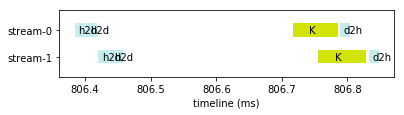

In [14]:
cuda_timeline.plot_trace(df_trace_2cke)

# GroundTruth

### 1 cke

In [15]:
df_single_stream = read_trace.Get_timing_from_trace(df_trace)
# print df_single_stream

tot_runtime = read_trace.GetTotalRuntime(df_single_stream)
print tot_runtime

0.279141


### 2 cke

In [16]:
df_2stream = read_trace.Get_timing_from_trace(df_trace_2cke)
print df_2stream

tot_runtime = read_trace.GetTotalRuntime(df_2stream)
print tot_runtime

   stream api_type       start         end      size  duration
0     0.0      h2d  806.383704  806.400408  89.84375  0.016704
1     0.0      h2d  806.401624  806.418041  89.84375  0.016417
2     0.0     kern  806.716992  806.786081   0.00000  0.069089
3     0.0      d2h  806.788705  806.804642  89.84375  0.015937
4     1.0      h2d  806.419321  806.435897  89.84375  0.016576
5     1.0      h2d  806.437113  806.458106  89.84375  0.020993
6     1.0     kern  806.755233  806.829026   0.00000  0.073793
7     1.0      d2h  806.832162  806.848035  89.84375  0.015873
0.464331


# Start Modeling CKE

In [17]:
df_s1 = read_trace.Reset_starting(df_single_stream)
print df_s1

   stream api_type     start       end      size  duration
0     0.0      h2d  0.000000  0.016641  89.84375  0.016641
1     0.0      h2d  0.018081  0.034209  89.84375  0.016128
2     0.0     kern  0.200611  0.257572   0.00000  0.056961
3     0.0      d2h  0.263236  0.279141  89.84375  0.015905


In [18]:
df_2stream_trace = read_trace.Reset_starting(df_2stream)
print df_2stream_trace

   stream api_type     start       end      size  duration
0     0.0      h2d  0.000000  0.016704  89.84375  0.016704
1     0.0      h2d  0.017920  0.034337  89.84375  0.016417
2     0.0     kern  0.333288  0.402377   0.00000  0.069089
3     0.0      d2h  0.405001  0.420938  89.84375  0.015937
4     1.0      h2d  0.035617  0.052193  89.84375  0.016576
5     1.0      h2d  0.053409  0.074402  89.84375  0.020993
6     1.0     kern  0.371529  0.445322   0.00000  0.073793
7     1.0      d2h  0.448458  0.464331  89.84375  0.015873


## model two streams

In [19]:
stream_num = 2

# find when to start the stream and update the starting pos for the trace
H2D_H2D_OVLP_TH = 3.158431

df_cke_list = cke.init_trace_list(df_s1, stream_num = stream_num, h2d_ovlp_th = H2D_H2D_OVLP_TH)

In [20]:
# df_cke_list[0]

In [21]:
# df_cke_list[1]

In [22]:
df_all_api = cke.init_sort_api_with_extra_cols(df_cke_list)

In [23]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,pred_end
0,0.000000,0.016641,h2d,89.84375,0.0,sleep,5398.939367,0.0,89.84375,0.0,0.0
1,0.018081,0.034209,h2d,89.84375,0.0,sleep,5570.669023,0.0,89.84375,0.0,0.0
4,0.036209,0.052850,h2d,89.84375,1.0,sleep,5398.939367,0.0,89.84375,0.0,0.0
5,0.054290,0.070418,h2d,89.84375,1.0,sleep,5570.669023,0.0,89.84375,0.0,0.0
2,0.200611,0.257572,kern,0.00000,0.0,sleep,0.000000,0.0,0.00000,0.0,0.0
6,0.236820,0.293781,kern,0.00000,1.0,sleep,0.000000,0.0,0.00000,0.0,0.0
3,0.263236,0.279141,d2h,89.84375,0.0,sleep,5648.773970,0.0,89.84375,0.0,0.0
7,0.299445,0.315350,d2h,89.84375,1.0,sleep,5648.773970,0.0,89.84375,0.0,0.0


### start algo

In [24]:
count = 0
# break_count = 7
break_count = 7

while not cke.AllDone(df_all_api):
    count = count + 1
    #if count == break_count: break
    
    #-----------------------
    # pick two api to model 
    #-----------------------
    df_all_api, r1, r2 = cke.PickTwo(df_all_api)
    
    #if count == break_count: break

    #-----------------------
    # check the last api or not 
    #-----------------------
    last_api = False
    if r1 == None and r2 == None:
        last_api = True
        
    if last_api == True:                          # go directly updating the last wake api
        df_all_api = cke.UpdateStream_lastapi(df_all_api)
        break
    
    
    #-----------------------
    # move the current_pos to the starting of coming api r2, and update r1 status
    #-----------------------
    df_all_api = cke.StartNext_byType(df_all_api, [r1, r2])
    
    #if count == break_count: break

    #-----------------------------
    # if one call is done, continue the next round
    #-----------------------------
    if cke.CheckRowDone(df_all_api, r1, r2):
        continue
        
    #if count == break_count: break
        
    #-----------------------------
    # when all calls are active
    #-----------------------------
    
    #-----------------------------
    # check whether the two calls are kerns, if yes
    #-----------------------------
    whichType = cke.CheckType(df_all_api, r1, r2) # check whether the same api
    if whichType == None:
        df_all_api = cke.Predict_noConflict(df_all_api, r1, r2)
    elif whichType in ['h2d', 'd2h']: # data transfer in the same direction
        df_all_api = cke.Predict_transferOvlp(df_all_api, r1, r2, ways = 2.0)
    else: # concurrent kernel: todo
        print('run cke model')
        
        #cke.model_2cke(df_all_api, r1, r2)
        #if count == break_count: break
            
        r1_sid, r1_kid =cke.FindStreamAndKernID(df_all_api, r1)
        #print('r1_stream_id {} , r1_kernel_id {}'.format(r1_sid, r1_kid))
        r2_sid, r2_kid =cke.FindStreamAndKernID(df_all_api, r2)
        #print('r2_stream_id {} , r2_kernel_id {}'.format(r2_sid, r2_kid))
        r1_start_ms = cke.GetStartTime(df_all_api, r1)
        r2_start_ms = cke.GetStartTime(df_all_api, r2)
        
        #print r1_start_ms
        #print r2_start_ms
        
        #print('before:')
        #print('r1 start :{} r2 start : {}'.format(stream_kernel_list[r1_sid][r1_kid].start_ms,
        #                                         stream_kernel_list[r2_sid][r2_kid].start_ms))
        
        stream_kernel_list[0][0].start_ms = r1_start_ms
        stream_kernel_list[1][0].start_ms = r2_start_ms
        
        
        #print('after:')
        #print('r1 start :{} r2 start : {}'.format(stream_kernel_list[r1_sid][r1_kid].start_ms,
        #                                        stream_kernel_list[r2_sid][r2_kid].start_ms))
        

        #Dump_kern_info(stream_kernel_list[r1_sid][r1_kid])
        #Dump_kern_info(stream_kernel_list[r2_sid][r2_kid])
        
        kernels_ = []
        kernels_.append(stream_kernel_list[r1_sid][r1_kid])
        kernels_.append(stream_kernel_list[r2_sid][r2_kid])

        SM_resList, SM_traceList = avgblk.cke_model(gtx950, SM_resList, SM_traceList, kernels_)
        
        # find the kernel execution time from the sm trace table
        result_kernel_runtime_dd = avgblk.Get_KernTime(SM_traceList)
        
        #print result_kernel_runtime_dd
        
        result_r1_start = result_kernel_runtime_dd[0][0]
        result_r1_end = result_kernel_runtime_dd[0][1]
        
        result_r2_start = result_kernel_runtime_dd[1][0]
        result_r2_end = result_kernel_runtime_dd[1][1]
        
        # r1 will be the 1st in dd, r2 will be the 2nd 
        df_all_api.set_value(r1, 'pred_end', result_r1_end)
        df_all_api.set_value(r2, 'pred_end', result_r2_end)   # Warning: it is better to have a pred_start
                                                              # Warning: but we care about the end timing for now

        
    #if count == break_count: break
        
        

    # check any of r1 and r2 has status done. if done, go to next 


    rangeT = cke.Get_pred_range(df_all_api)
    print rangeT

    #if count == break_count: break

    extra_conc = cke.Check_cc_by_time(df_all_api, rangeT) # check whether there is conc during the rangeT
    print('extra_conc {}'.format(extra_conc))
    
    #if count == break_count: break
        
    if extra_conc == 0:
        if whichType in ['h2d', 'd2h']:
            df_all_api = cke.Update_wake_transferOvlp(df_all_api, rangeT, ways = 2.0)
        elif whichType == 'kern':
            df_all_api = cke.Update_wake_kernOvlp(df_all_api)
        else: # no overlapping
            df_all_api = cke.Update_wake_noConflict(df_all_api, rangeT)

        #if count == break_count: break
            
        # check if any api is done, and update the timing for the other apis in that stream
        df_all_api = cke.UpdateStreamTime(df_all_api)
        
        #if count == break_count: break

    else: # todo : when there is additional overlapping
        pass

#         if count == break_count:
#             break
        


row:0 row:1
row:1 row:4
row:4 row:5
row:5 row:2
row:2 row:6
run cke model
[0.23682000000001335, 0.25757199999998193]
extra_conc 0
row:3 row:7
row:None row:None


In [25]:
df_all_api

,start,end,api_type,size_kb,stream_id,status,bw,bytes_done,bytes_left,current_pos,pred_end
0,0.000000,0.016641,h2d,89.84375,0.0,done,5398.939367,89.84375,0.0,0.016641,0.016641
1,0.018081,0.034209,h2d,89.84375,0.0,done,5570.669023,89.84375,0.0,0.034209,0.034209
4,0.036209,0.052850,h2d,89.84375,1.0,done,5398.939367,89.84375,0.0,0.052850,0.052850
5,0.054290,0.070418,h2d,89.84375,1.0,done,5570.669023,89.84375,0.0,0.070418,0.070418
2,0.200611,0.257572,kern,0.00000,0.0,done,0.000000,0.00000,0.0,0.257572,0.257572
6,0.236820,0.314533,kern,0.00000,1.0,done,0.000000,0.00000,0.0,0.314533,0.314533
3,0.263236,0.279141,d2h,89.84375,0.0,done,5648.773970,89.84375,0.0,0.279141,0.279141
7,0.320197,0.336102,d2h,89.84375,1.0,done,5648.773970,89.84375,0.0,0.336102,0.336102


In [26]:
df_2stream_trace

,stream,api_type,start,end,size,duration
0,0.0,h2d,0.000000,0.016704,89.84375,0.016704
1,0.0,h2d,0.017920,0.034337,89.84375,0.016417
2,0.0,kern,0.333288,0.402377,0.00000,0.069089
3,0.0,d2h,0.405001,0.420938,89.84375,0.015937
4,1.0,h2d,0.035617,0.052193,89.84375,0.016576
5,1.0,h2d,0.053409,0.074402,89.84375,0.020993
6,1.0,kern,0.371529,0.445322,0.00000,0.073793
7,1.0,d2h,0.448458,0.464331,89.84375,0.015873


In [27]:
df_s1

,stream,api_type,start,end,size,duration
0,0.0,h2d,0.000000,0.016641,89.84375,0.016641
1,0.0,h2d,0.018081,0.034209,89.84375,0.016128
2,0.0,kern,0.200611,0.257572,0.00000,0.056961
3,0.0,d2h,0.263236,0.279141,89.84375,0.015905


In [28]:
#
# run above
#